<a href="https://colab.research.google.com/github/YABIGAIL23/SIMULACION-I/blob/main/Inventario_5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##EJEMPLO 5.5 SISTEMA DE INVENTARIOS

In [1]:
#Librerias
import numpy as np
import pandas as pd
from itertools import product

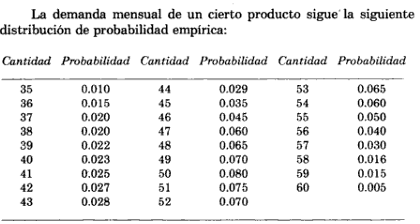

In [2]:
#Distribución de demanda mensual
demanda_dist = {
    35: 0.010, 36: 0.015, 37: 0.020, 38: 0.020, 39: 0.022,
    40: 0.023, 41: 0.025, 42: 0.027, 43: 0.028, 44: 0.029,
    45: 0.035, 46: 0.045, 47: 0.060, 48: 0.065, 49: 0.070,
    50: 0.080, 51: 0.075, 52: 0.070, 53: 0.065, 54: 0.060,
    55: 0.050, 56: 0.040, 57: 0.030, 58: 0.016, 59: 0.015,
    60: 0.005
}

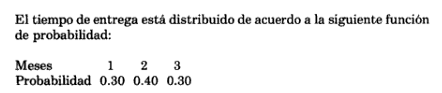

In [3]:
#Tiempo de entrega (meses)
lead_time_dist = {1: 0.3, 2: 0.4, 3: 0.3}

Los factores estacionales para cada uno de los meses del año son como se muestra a continuacion:

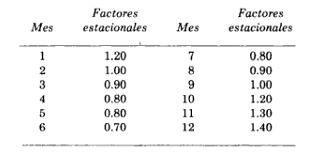

In [4]:
#Factores estacionales por mes
factores_estacionales = {
    1: 1.20, 2: 1.00, 3: 0.90, 4: 0.80, 5: 0.80,
    6: 0.70, 7: 0.80, 8: 0.90, 9: 1.00, 10: 1.20,
    11: 1.30, 12: 1.40
}

La informacon respecto a los costos es la siguiente:

- Costo de ordenar = \$100/orden
- Costo de inventario = \$20/unidad/año
- Costo faltante = \$50/unidad

In [5]:
#Costos
costo_ordenar = 100  #por orden
costo_inventario = 20  #por unidad por año
costo_faltante = 50  #por unidad

In [6]:
#Función para simular un año de operación
def simular_inventario(q, R, inventario_inicial=150, n_meses=12, verbose=False):
    inventario = inventario_inicial
    pedidos_pendientes = {}  #{mes_llegada: cantidad}
    costos = {
        'ordenar': 0,
        'inventario': 0,
        'faltante': 0
    }
    inventario_promedio_mensual = []
    faltantes_mensuales = []

    for mes in range(1, n_meses + 1):
        #Recibir pedidos si llegan este mes
        if mes in pedidos_pendientes:
            inventario += pedidos_pendientes[mes]
            del pedidos_pendientes[mes]

        #Simular demanda
        demanda_base = np.random.choice(list(demanda_dist.keys()), p=list(demanda_dist.values()))
        demanda_ajustada = int(demanda_base * factores_estacionales[mes])

        #Calcular inventario final y faltantes
        if inventario >= demanda_ajustada:
            inventario_final = inventario - demanda_ajustada
            faltantes = 0
        else:
            inventario_final = 0
            faltantes = demanda_ajustada - inventario

        #Calcular inventario promedio del mes
        inventario_promedio = (inventario + inventario_final) / 2
        if faltantes > 0:
            # Ajuste para períodos con faltantes
            inventario_promedio = (inventario**2) / (2 * demanda_ajustada)

        #Registrar costos
        costos['inventario'] += inventario_promedio * (costo_inventario / 12)
        costos['faltante'] += faltantes * costo_faltante

        #Verificar si se debe hacer un pedido
        if inventario_final <= R and mes not in pedidos_pendientes:
            # imular tiempo de entrega
            lead_time = np.random.choice(list(lead_time_dist.keys()), p=list(lead_time_dist.values()))
            mes_llegada = mes + lead_time
            pedidos_pendientes[mes_llegada] = q
            costos['ordenar'] += costo_ordenar

        if verbose:
            print(f"Mes {mes}: Inventario inicial={inventario}, Demanda={demanda_ajustada}, "
                  f"Inventario final={inventario_final}, Faltantes={faltantes}, "
                  f"Pedidos pendientes={pedidos_pendientes}")

        #Actualizar inventario para el próximo mes
        inventario = inventario_final
        inventario_promedio_mensual.append(inventario_promedio)
        faltantes_mensuales.append(faltantes)

    costo_total = sum(costos.values())
    return costo_total, costos

In [7]:
#Función para encontrar los parámetros óptimos
def encontrar_optimos(q_range, R_range, n_simulaciones=30):
    mejores_parametros = None
    mejor_costo = float('inf')
    resultados = []

    #Probar diferentes combinaciones de q y R
    for q, R in product(q_range, R_range):
        costo_promedio = 0

        #Realizar múltiples simulaciones para cada combinación
        for _ in range(n_simulaciones):
            costo, _ = simular_inventario(q, R)
            costo_promedio += costo

        costo_promedio /= n_simulaciones
        resultados.append((q, R, costo_promedio))

        if costo_promedio < mejor_costo:
            mejor_costo = costo_promedio
            mejores_parametros = (q, R)

    return mejores_parametros, mejor_costo, resultados

In [8]:
#Ejecutar la simulación y encontrar los valores óptimos
if __name__ == "__main__":
    #Rangos para buscar q y R
    q_range = range(150, 250, 10)  #De 150 a 250 en pasos de 10
    R_range = range(80, 180, 10)   #De 80 a 180 en pasos de 10

    #Encontrar los parámetros óptimos
    (q_optimo, R_optimo), costo_optimo, resultados = encontrar_optimos(q_range, R_range)

    print("\nResultados de la simulación:")
    print(f"Cantidad óptima a ordenar (q): {q_optimo}")
    print(f"Nivel óptimo de reorden (R): {R_optimo}")
    print(f"Costo total promedio anual: ${costo_optimo:.2f}")

    #Mostrar
    print("\nSimulación detallada con parámetros óptimos:")
    costo, costos = simular_inventario(q_optimo, R_optimo, verbose=True)
    print("\nDesglose de costos:")
    print(f"- Costo de ordenar: ${costos['ordenar']:.2f}")
    print(f"- Costo de llevar inventario: ${costos['inventario']:.2f}")
    print(f"- Costo de faltante: ${costos['faltante']:.2f}")
    print(f"Costo total anual: ${costo:.2f}")


Resultados de la simulación:
Cantidad óptima a ordenar (q): 160
Nivel óptimo de reorden (R): 100
Costo total promedio anual: $3716.44

Simulación detallada con parámetros óptimos:
Mes 1: Inventario inicial=150, Demanda=43, Inventario final=107, Faltantes=0, Pedidos pendientes={}
Mes 2: Inventario inicial=107, Demanda=53, Inventario final=54, Faltantes=0, Pedidos pendientes={np.int64(3): 160}
Mes 3: Inventario inicial=214, Demanda=37, Inventario final=177, Faltantes=0, Pedidos pendientes={}
Mes 4: Inventario inicial=177, Demanda=35, Inventario final=142, Faltantes=0, Pedidos pendientes={}
Mes 5: Inventario inicial=142, Demanda=39, Inventario final=103, Faltantes=0, Pedidos pendientes={}
Mes 6: Inventario inicial=103, Demanda=28, Inventario final=75, Faltantes=0, Pedidos pendientes={np.int64(9): 160}
Mes 7: Inventario inicial=75, Demanda=41, Inventario final=34, Faltantes=0, Pedidos pendientes={np.int64(9): 160}
Mes 8: Inventario inicial=34, Demanda=47, Inventario final=0, Faltantes=13,